# Ray cast vizualizations

Code to check if rays are being cast correctly. Modified from original to avoid using trimesh; will work with 

In [1]:
# Imports

import torch
import torch.nn as nn
import numpy as np
import open3d
# import trimesh
import tensorflow as tf
from tensorflow.compat.v1 import enable_eager_execution
enable_eager_execution()
import matplotlib.pyplot as plt

256 256
(5, 256, 256, 4) (5, 4, 4) [35. 35. 35. 35. 35.]


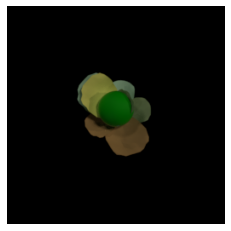

In [2]:
# Data Loading

data = np.load('/home/sushmitawarrier/clevr-dataset-gen/output/GPU_data_rsynced/CLEVR_new000000/images/CLEVR_new000000/lettuce_scene000000_transforms_4.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
# verts = data['verts']
H, W = images.shape[1:3]
print(H, W)
print(images.shape, poses.shape, focal)

testimg, testpose = images[4], poses[4]
images = images[:3,...,:3]
poses = poses[:3]

plt.imshow(testimg)
plt.axis("off")
plt.show()


In [3]:
import numpy as np

def face_process(face_list):
	faces=list(map(lambda x:int(x.split(b'/')[0]),face_list[1:]))
	return faces

def load_obj(filename):
	f=open(filename,"rb")
	lines = f.readlines()

	verts=list(filter(lambda x:x[:2]==b"v ", lines))
	faces=list(filter(lambda x:x[:2]==b"f ", lines))

	verts=list(map(lambda x:x.strip().split()[1:],verts))
	verts=np.array(verts).astype("float32")
	faces=list(map(lambda x:x.strip().split(),faces))
	faces=list(map(face_process,faces))
	faces=np.array(faces).astype("int32")-1

	return lines,verts, faces

In [4]:
# !ls ../output/GPU_data_rsynced/CLEVR_new000000/objfiles

lines, verts, faces = load_obj('../output/GPU_data_rsynced/CLEVR_new000000/objfiles/000004.obj')

In [5]:
data = np.load('/home/sushmitawarrier/clevr-dataset-gen/output/GPU_data_rsynced/CLEVR_new000000/images/CLEVR_new000000/lettuce_scene000000_transforms_base_dist.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

In [6]:
homogenize=np.ones((verts.shape[0],1))
verts_h = np.concatenate([verts,homogenize],axis=1)

verts_hc = verts_h.copy()
#verts_hc[:,1] = verts_h[:,2]
#verts_hc[:,2] = verts_h[:,0]
#verts_hc[:,0] = verts_h[:,1]



In [7]:
verts_hc

array([[-0.090254  ,  0.007464  ,  0.040401  ,  1.        ],
       [ 0.51638901,  0.300156  ,  0.25070301,  1.        ],
       [-0.115507  ,  0.01107   ,  0.037663  ,  1.        ],
       ...,
       [ 0.58562303,  1.349298  ,  0.038803  ,  1.        ],
       [ 0.612221  ,  1.33343303, -0.090776  ,  1.        ],
       [ 0.58890003,  1.30776596, -0.21443   ,  1.        ]])

In [8]:
import torch as th

rot=poses[4][:3, :3]
rot_c = rot.copy()
#rot_c[2] = -rot[2]

trans=poses[4][:3,3]
trans_c = trans.copy()
#trans_c[0]=trans[1]
#trans_c[1]=trans[0]


#projections=th.matmul(torch.from_numpy(verts).float(),torch.from_numpy(poses[1][:3,:3]).float())-torch.from_numpy(trans_c).float()
projections=th.matmul(torch.from_numpy(verts_hc).float(),torch.from_numpy(poses[4]).T.float()) #-torch.from_numpy(trans_c).float()

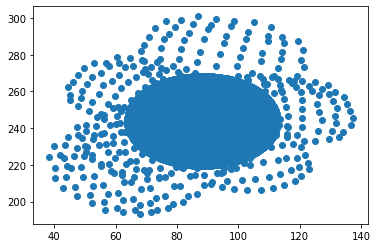

In [9]:
points=projections
y= focal[4]*points[:,1] #/(points[:,2])
x= focal[4]*points[:,0] #/(points[:,2])
plt.scatter(y,x)

In [10]:
points[:,0]

tensor([7.3522, 7.1829, 7.3568,  ..., 6.5017, 6.3938, 6.3122])

In [11]:
points

tensor([[7.3522, 2.5652, 4.3937, 1.0000],
        [7.1829, 3.1491, 4.7519, 1.0000],
        [7.3568, 2.5400, 4.3955, 1.0000],
        ...,
        [6.5017, 2.9761, 5.5621, 1.0000],
        [6.3938, 2.9653, 5.4847, 1.0000],
        [6.3122, 2.9110, 5.4016, 1.0000]])

In [12]:
trans_c

array([7.29177999, 2.63929391, 4.36738586])

(-0.5, 255.5, 316.0039596557617, -0.5)

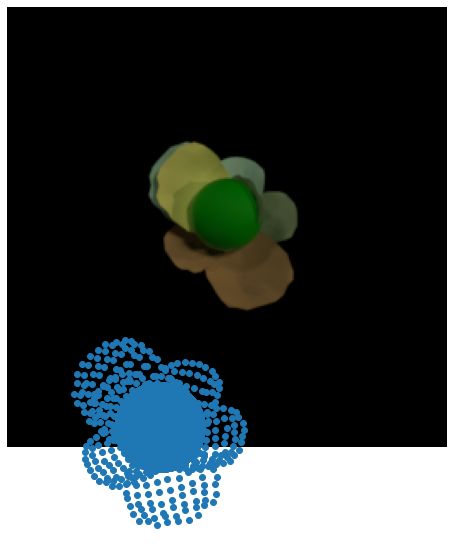

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(images[4][:,:,:3])
plt.scatter(y,x)
plt.axis("off")

In [14]:
images[4].shape

(256, 256, 4)

In [72]:
# Helper functions

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
def pos_enc(a,L):
    
    x=[torch.sin(2.**i*a) for i in range(L)] + [torch.sin(2.**i*np.pi*a) for i in range(L)] + [a]
    
    return torch.cat(x,dim=0)


class NeRF(nn.Module):
    
    def __init__(self,Lp):
        super().__init__()
        self.Lp = Lp
        
        module = []
        
        module.extend([nn.Linear(3*2*Lp+3,256),nn.ReLU()])
        
        # 7 layers
        for i in range(7):
            module.extend([nn.Linear(256,256),nn.ReLU()])
        
        module.extend([nn.Linear(256,4)])
        self.nerf = nn.Sequential(*module)
        
        self.apply(lambda x: init_weights(x))
        
    def forward(self, input):
        
        inp = pos_enc(input,self.Lp)
        print("inp before permute", inp.shape)
        inp = inp.permute(1, 0,2)
        print("inp before reshape", inp.shape)
        inp = inp.reshape([inp.shape[0],-1])
        print("inp shape", inp.shape)
        
        rgba = self.nerf(inp)
        return torch.sigmoid(rgba[:,:3]), torch.relu(rgba[:,3])
    

        

In [73]:
pos_enc(pw, 6).shape

torch.Size([13, 6250, 3])

In [74]:
nerf=NeRF(6)
optim=torch.optim.Adam(nerf.parameters(),0.001,(0.9,0.99))

In [75]:
# Tf compares
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i*10-50)/focal, -(j*10-50)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o.numpy(), rays_d.numpy(), dirs.numpy()
rays_o, rays_d, dirs = get_rays(H/10,W/10, focal[0], poses[0])

##
c2w=torch.from_numpy(poses[0])
#gur=th.bmm(p,c2w[:3,:3].T.view(1,3,3))

##
rays_o, rays_d
N_samples = 10
z_vals = tf.linspace(5.0, 8.0, N_samples)
z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (8.0-5.0)/N_samples
#pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

In [76]:
import torch as th

def cast_rays(H, W, focal, scale, c2w, ns):
    
    nx = H // scale
    ny = W // scale
    #ns = nb_samples
    
    
    # Sample front plane
    yy,xx = torch.meshgrid(torch.linspace(0,ny-1,ny),torch.linspace(0,nx-1,nx))
    # scaling factor
    o = torch.Tensor(1,nx*ny,1).fill_(1)
    
    ix = xx.reshape(1,-1)*scale
    iy = yy.reshape(1,-1)*scale
    points = th.cat([(ix.unsqueeze(-1)-W/2)/focal, -(iy.unsqueeze(-1)-H/2)/focal, -o], dim=-1)
    
    camtrans = -torch.matmul(c2w[:3,-1],c2w[:3,:3])
    near_distance = camtrans
    far_distance = camtrans+5
    
    t=torch.linspace(0,1,ns)
    # add jitter to sampling direction, so we get non-uniform samples
    t_noisy = t.view(1,ns,1,1) + torch.Tensor(1,ns,nx*ny,1).uniform_(0,1)/ns
    
    t_scale = t_noisy*far_distance + (1-t_noisy)*near_distance
    points_move = t_scale * points.view(1,1,nx*ny,3)
    
    points_world = th.bmm((points_move).view(1,-1,3),c2w[:3,:3].T.view(1,3,3)) 
    
    return points, points_move.view(1,-1,3), points_world

def raytrace(z,sigma_a,rgb):
    dists = th.cat([z[..., 1:,:] - z[..., :-1,:], th.ones_like(z[...,:1,:]).fill_(1e10)], -1) 
    alpha = 1.-th.exp(-sigma_a * dists)  
    weights = alpha * th.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = (weights[...,None] * rgb).sum(dim=-2) 
    depth_map =(weights * z_vals).sum(dim=-1)
    acc_map = weights.sum(dim=-1)

    return rgb_map, depth_map, acc_map

In [77]:
cast_rays(H,W,focal[0],10,torch.from_numpy(poses[img_i]),64)

(tensor([[[-3.6571,  3.6571, -1.0000],
          [-3.3714,  3.6571, -1.0000],
          [-3.0857,  3.6571, -1.0000],
          ...,
          [ 2.6286, -3.2000, -1.0000],
          [ 2.9143, -3.2000, -1.0000],
          [ 3.2000, -3.2000, -1.0000]]]),
 tensor([[[ -0.2253,   0.2253,   9.8539],
          [ -0.1546,   0.1677,   9.8696],
          [ -0.1674,   0.1985,   9.8612],
          ...,
          [ 13.1837, -16.0497,   4.9000],
          [ 14.6469, -16.0829,   4.8896],
          [ 16.1339, -16.1339,   4.8736]]], dtype=torch.float64),
 tensor([[[  9.5764,   2.3328,   0.2253],
          [  9.5733,   2.4051,   0.1677],
          [  9.5685,   2.3905,   0.1985],
          ...,
          [  1.3208,  14.0026, -16.0497],
          [  0.9321,  15.4133, -16.0829],
          [  0.5318,  16.8455, -16.1339]]], dtype=torch.float64))

In [78]:
p,pm,pw=cast_rays(H,W,focal[0],10,torch.from_numpy(poses[img_i]),10)
    

In [82]:
# Train

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = torch.from_numpy(images[img_i]).unsqueeze(0)
    print("tagert shape", target.shape)
    pose = torch.from_numpy(poses[img_i]).unsqueeze(0)
    p,pm,pw=cast_rays(H,W,focal[0],10,torch.from_numpy(poses[img_i]),10)
    print(pw.shape)
    
    rgb,alpha=nerf(pw.float()) #.type(torch.FloatTensor))
    print("rgb shape", rgb.shape)
    
    loss = th.mean((rgb - target).pow(2))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal[0], testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

tagert shape torch.Size([1, 256, 256, 3])
torch.Size([1, 6250, 3])
inp before permute torch.Size([13, 6250, 3])
inp before reshape torch.Size([6250, 13, 3])
inp shape torch.Size([6250, 39])
rgb shape torch.Size([6250, 3])


RuntimeError: The size of tensor a (6250) must match the size of tensor b (256) at non-singleton dimension 2

In [81]:
import open3d

p,pm,pw=cast_rays(H,W,focal[0],10,torch.from_numpy(poses[0]),10)
p,pm,pw_2=cast_rays(H,W,focal[0],10,torch.from_numpy(poses[2]),10)

In [ ]:
# we have replaced this with values from the .npz file
# mesh=trimesh.load('./mesh.obj')
# verts=np.array(mesh.vertices)

In [36]:
# Point clouds
viz=open3d.JVisualizer()

pcd1 = open3d.geometry.PointCloud()
pcd1.points = open3d.utility.Vector3dVector(p[0].numpy())
pcd1.paint_uniform_color(np.array([1,0,0],dtype=np.float32))

pcd2 = open3d.geometry.PointCloud()
pcd2.points = open3d.utility.Vector3dVector(pm[0].numpy())
pcd2.paint_uniform_color(np.array([0,1,0],dtype=np.float32))

pcd3 = open3d.geometry.PointCloud()
pcd3.points = open3d.utility.Vector3dVector(pw[0].numpy())
pcd3.paint_uniform_color(np.array([0,0,1],dtype=np.float32))

# pcd4 = open3d.geometry.PointCloud()
# pcd4.points = open3d.utility.Vector3dVector(pw_2[0].numpy())
# pcd4.paint_uniform_color(np.array([1,0,1],dtype=np.float32))

pcd5=open3d.geometry.PointCloud()
pcd5.points = open3d.utility.Vector3dVector(verts)
pcd5=pcd5.uniform_down_sample(100)
pcd5.paint_uniform_color(np.array([0,1,1],dtype=np.float32))

AttributeError: module 'open3d' has no attribute 'JVisualizer'

In [ ]:
viz=open3d.JVisualizer()

viz.add_geometry(pcd5)
viz.add_geometry(pcd1)
viz.show()

In [ ]:
viz=open3d.JVisualizer()

viz.add_geometry(pcd5)
viz.add_geometry(pcd2)
viz.show()

In [ ]:
viz=open3d.JVisualizer()

viz.add_geometry(pcd5)
viz.add_geometry(pcd3)
viz.show()

In [ ]:
plt.imshow(images[0])
plt.axis("off")

In [ ]:
viz=open3d.JVisualizer()

viz.add_geometry(pcd5)
viz.add_geometry(pcd3)
viz.add_geometry(pcd4)
viz.show()

## Debug

In [ ]:
pcd5 = open3d.geometry.PointCloud()
pcd5.points = open3d.utility.Vector3dVector(pws[0].numpy())
pcd5.paint_uniform_color(np.array([1,0,1],dtype=np.float32))

pcd6 = open3d.geometry.PointCloud()
pcd6.points = open3d.utility.Vector3dVector(pts_tp)
pcd6.paint_uniform_color(np.array([1,1,0],dtype=np.float32))

In [ ]:
pws=pw.clamp(-1.5,1.5)

In [ ]:
#viz.add_geometry(pcd3)
viz=open3d.JVisualizer()

viz.add_geometry(pcd5)
#viz.add_geometry(pcd6)
viz.add_geometry(pcd4)
viz.show()
del viz

In [ ]:
mesh=trimesh.load('./mesh.obj')

In [ ]:
g=np.array(mesh.vertices)

In [ ]:
g[:,0]=g[:,0]
g[:,1]=g[:,1]
g[:,2]=-g[:,2]

In [ ]:
pcd4=open3d.geometry.PointCloud()
pcd4.points = open3d.utility.Vector3dVector(k)
pcd4=pcd4.uniform_down_sample(100)
pcd4.paint_uniform_color(np.array([0,0,1],dtype=np.float32))


In [ ]:
pcd5=open3d.geometry.PointCloud()
pcd5.points = open3d.utility.Vector3dVector(points[0].numpy())
pcd5=pcd5.uniform_down_sample(100)
pcd5.paint_uniform_color(np.array([1,1,1],dtype=np.float32))

In [ ]:
k=g[:,(1,0,2)]
l=th.from_numpy(k)

In [ ]:
lm=th.cat([l.float().unsqueeze(0),torch.ones_like(l).float().unsqueeze(0)],dim=-1)
lm=lm[:,:,:4]

In [ ]:
c2w=torch.from_numpy(poses[2])
points=th.bmm(l.float().unsqueeze(0),c2w[:3,:3].unsqueeze(0)) 

In [ ]:
z=l[:,:2]
pts=z*focal[0]

In [ ]:
plt.imshow(images[2])
plt.scatter(pts[:,0]+50,pts[:,1]+50,alpha=0.3)

In [ ]:
pts.shape

In [ ]:
plt.imshow(images[2])

In [ ]:
poses[0]